## Optics simulation (full)
From telescope entrance to focal plane after Lyot plate

In [77]:
from __future__ import division
exec(open('./prep.py'))
exec(open('./codes/func.py'))
exec(open('./codes/util.py'))
% matplotlib inline

---
## Masks
## <font color="red">later wrap below to a class or something (including plotting, unit conversions...)</font>

### Incident light

In [3]:
N_pix = 4096
One = np.ones((N_pix,N_pix))
Zer = np.zeros((N_pix,N_pix))

### Masks
#### read in...

In [4]:
primary_path  = '../masks/gemini_primary.fits'

## Y band - 1.02 um
apod_y_path = '../masks/gpi_y_apodizer.fits'
lyot_y_path = '../masks/gpi_y_lyot.fits'
fpm_y_path = '../masks/gpi_y_fpm.fits'
## J band - 1.22 um
apod_j_path = '../masks/gpi_j_apodizer.fits'
lyot_j_path = '../masks/gpi_j_lyot.fits'
fpm_j_path = '../masks/gpi_j_fpm.fits'
## H band - 1.65 um
apod_h_path = '../masks/gpi_h_apodizer.fits'
lyot_h_path = '../masks/gpi_h_lyot.fits'
fpm_h_path = '../masks/gpi_h_fpm.fits'
## K band - 2.19 um ; use K1
apod_k_path = '../masks/gpi_k1_apodizer.fits'
lyot_k_path = '../masks/gpi_k1_lyot.fits'
fpm_k_path = '../masks/gpi_k1_fpm.fits'

In [5]:
pri_d, pri_h  = read_fits(primary_path)

apo_y_d, apo_y_h  = read_fits(apod_y_path)
apo_j_d, apo_j_h  = read_fits(apod_j_path)
apo_h_d, apo_h_h  = read_fits(apod_h_path)
apo_k_d, apo_k_h  = read_fits(apod_k_path)

fpm_y_d, fpm_y_h  = read_fits(fpm_y_path)
fpm_j_d, fpm_j_h  = read_fits(fpm_j_path)
fpm_h_d, fpm_h_h  = read_fits(fpm_h_path)
fpm_k_d, fpm_k_h  = read_fits(fpm_k_path)

lyo_y_d, lyo_y_h  = read_fits(lyot_y_path)
lyo_j_d, lyo_j_h  = read_fits(lyot_j_path)
lyo_h_d, lyo_h_h  = read_fits(lyot_h_path)
lyo_k_d, lyo_k_h  = read_fits(lyot_k_path)

#### Take a look - for 'scaling'

Size = 1024 pixels; pixel scale = 0.0078125


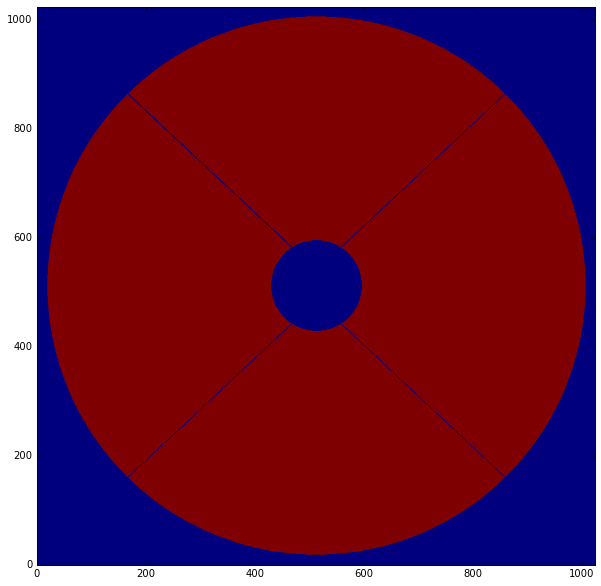

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(pri_d,origin='lower')
print 'Size = %s pixels; pixel scale = %s' %(pri_h['NAXIS1'],pri_h['pixscale'])

Y band

Apodizer    size = 1024 pixels; pixel scale = 0.0078125
Coronagraph size = 1024 pixels; pixel scale = 0.00263671875
Lyot mask   size = 1024 pixels; pixel scale = 0.0078125


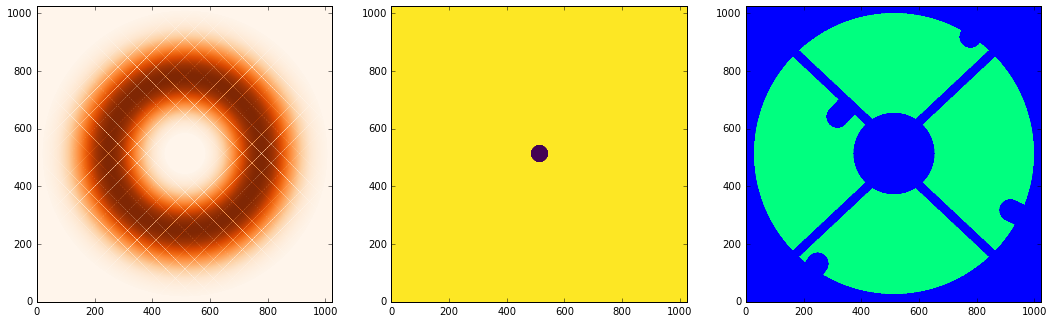

In [7]:
plt.figure(figsize=(18,36))
plt.subplot(131); plt.imshow(apo_y_d,origin='lower',cmap=plt.get_cmap('Oranges'))
plt.subplot(132); plt.imshow(fpm_y_d,origin='lower',cmap=plt.get_cmap('viridis'))
plt.subplot(133); plt.imshow(lyo_y_d,origin='lower',cmap=plt.get_cmap('winter'))
print 'Apodizer    size = %s pixels; pixel scale = %s' %(apo_y_h['NAXIS1'],apo_y_h['pixscale'])
print 'Coronagraph size = %s pixels; pixel scale = %s' %(fpm_y_h['NAXIS1'],fpm_y_h['pixscale'])
print 'Lyot mask   size = %s pixels; pixel scale = %s' %(lyo_y_h['NAXIS1'],lyo_y_h['pixscale'])

J band

Apodizer    size = 1024 pixels; pixel scale = 0.0078125
Coronagraph size = 1024 pixels; pixel scale = 0.00263671875
Lyot mask   size = 1024 pixels; pixel scale = 0.0078125


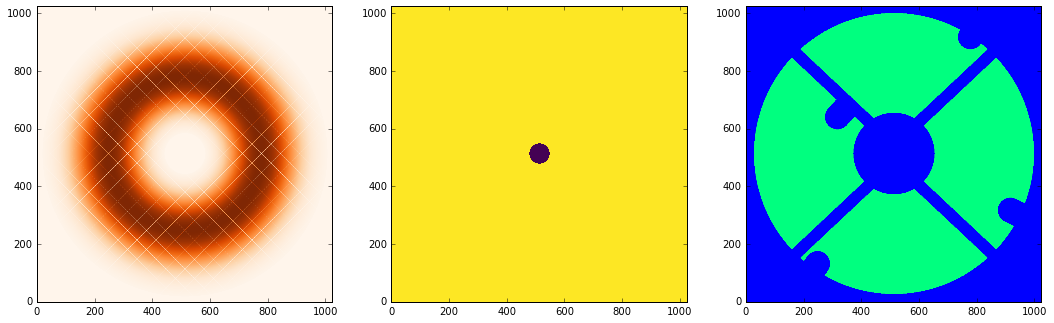

In [8]:
plt.figure(figsize=(18,36))
plt.subplot(131); plt.imshow(apo_j_d,origin='lower',cmap=plt.get_cmap('Oranges'))
plt.subplot(132); plt.imshow(fpm_j_d,origin='lower',cmap=plt.get_cmap('viridis'))
plt.subplot(133); plt.imshow(lyo_j_d,origin='lower',cmap=plt.get_cmap('winter'))
print 'Apodizer    size = %s pixels; pixel scale = %s' %(apo_j_h['NAXIS1'],apo_j_h['pixscale'])
print 'Coronagraph size = %s pixels; pixel scale = %s' %(fpm_j_h['NAXIS1'],fpm_j_h['pixscale'])
print 'Lyot mask   size = %s pixels; pixel scale = %s' %(lyo_j_h['NAXIS1'],lyo_j_h['pixscale'])

H band

Apodizer    size = 1024 pixels; pixel scale = 0.0078125
Coronagraph size = 1024 pixels; pixel scale = 0.00263671875
Lyot mask   size = 1024 pixels; pixel scale = 0.0078125


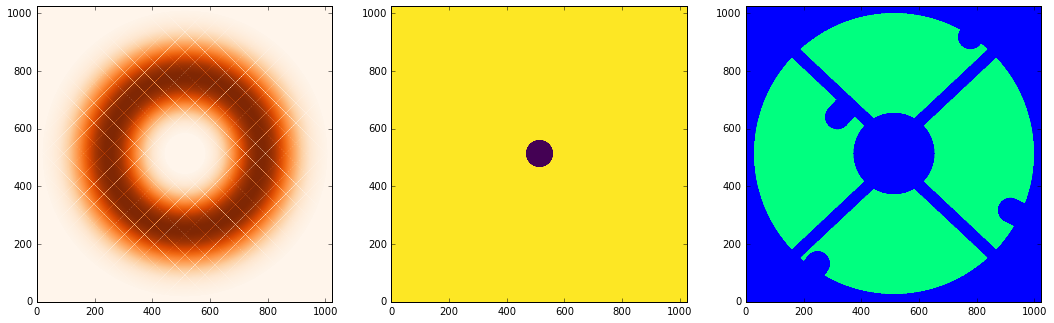

In [9]:
plt.figure(figsize=(18,36))
plt.subplot(131); plt.imshow(apo_h_d,origin='lower',cmap=plt.get_cmap('Oranges'))
plt.subplot(132); plt.imshow(fpm_h_d,origin='lower',cmap=plt.get_cmap('viridis'))
plt.subplot(133); plt.imshow(lyo_h_d,origin='lower',cmap=plt.get_cmap('winter'))
print 'Apodizer    size = %s pixels; pixel scale = %s' %(apo_h_h['NAXIS1'],apo_h_h['pixscale'])
print 'Coronagraph size = %s pixels; pixel scale = %s' %(fpm_h_h['NAXIS1'],fpm_h_h['pixscale'])
print 'Lyot mask   size = %s pixels; pixel scale = %s' %(lyo_h_h['NAXIS1'],lyo_h_h['pixscale'])

K band (k1)

Apodizer    size = 1024 pixels; pixel scale = 0.0078125
Coronagraph size = 1024 pixels; pixel scale = 0.00263671875
Lyot mask   size = 1024 pixels; pixel scale = 0.0078125


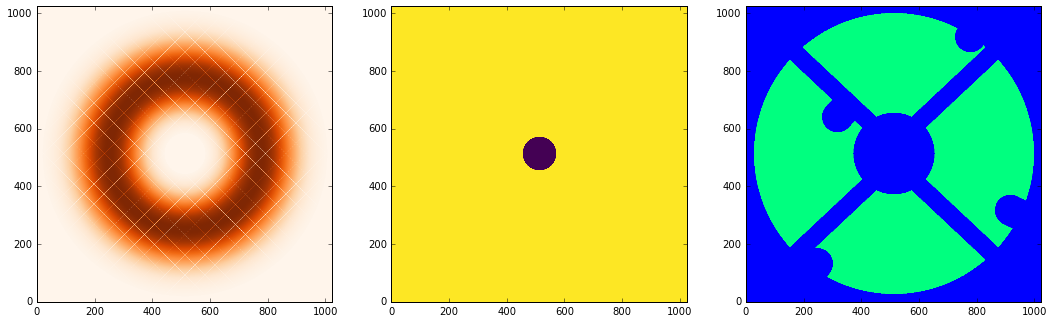

In [10]:
plt.figure(figsize=(18,36))
plt.subplot(131); plt.imshow(apo_k_d,origin='lower',cmap=plt.get_cmap('Oranges'))
plt.subplot(132); plt.imshow(fpm_k_d,origin='lower',cmap=plt.get_cmap('viridis'))
plt.subplot(133); plt.imshow(lyo_k_d,origin='lower',cmap=plt.get_cmap('winter'))
print 'Apodizer    size = %s pixels; pixel scale = %s' %(apo_k_h['NAXIS1'],apo_k_h['pixscale'])
print 'Coronagraph size = %s pixels; pixel scale = %s' %(fpm_k_h['NAXIS1'],fpm_k_h['pixscale'])
print 'Lyot mask   size = %s pixels; pixel scale = %s' %(lyo_k_h['NAXIS1'],lyo_k_h['pixscale'])

As expected the coronagraph and Lyot mask changes sizes accordingly with the wavelength.

_(Note: An attempt to expand the arrays into 1025 x 1025 failed because the interpolations would inevitably introduce non-zero numbers at pixels that must be zero, and vice versa. Instead, I modified the inputs to now have 1024 x 1024 grid)_

#### How big is the 'primary'?
This determines the 'sampling frequency' as defined in the `sim_opt` [notebook](https://github.com/Mipanox/GPI_stuff/blob/master/sim_opt.ipynb).

In [11]:
# parameters
D_tel = 7.8 * u.m
lba_h = 1.65 * u.um

## extension of the primary mask
allowedx = np.where(pri_d==1)[0]
Sampfreq = N_pix / (allowedx.max()-allowedx.min())

## 
pix_scale = D_tel / N_pix * Sampfreq ## physical scale
k_pix_arc = ((lba_h/Sampfreq/D_tel).to(u.dimensionless_unscaled)*u.rad).to(u.arcsec)
R_tel_p = N_pix / Sampfreq / 2 ## in pixel

## Inputs

To guarantee enough resolution, the masks cannot be binned. But DFT makes a large aperture small in the focal plane (and thus limited resolution there), so we need to pad the masks to the larger size...

In [12]:
pri_p = pad_array(pri_d,N_pix)

apo_y_p = pad_array(apo_y_d,N_pix)
apo_j_p = pad_array(apo_j_d,N_pix)
apo_h_p = pad_array(apo_h_d,N_pix)
apo_k_p = pad_array(apo_k_d,N_pix)

lyo_y_p = pad_array(lyo_y_d,N_pix)
lyo_j_p = pad_array(lyo_j_d,N_pix)
lyo_h_p = pad_array(lyo_h_d,N_pix)
lyo_k_p = pad_array(lyo_k_d,N_pix)

### Star light

In [13]:
Str_amp = One * pri_p
Str_pha = Zer * pri_p * u.rad

### Planet light
a point source with a "tip" in phase

In [15]:
## we can make it dimmer...
Pnt_amp = One * pri_p * 0.1 

## let's say... the planent is 1 arcsec away from the star, 
#  so the corresponding phase shift is D_tel * 1''
p_shift = (D_tel*1*u.arcsec).to(u.nm*u.rad).value
tilt = (p_shift*u.nm/lba_h).to(u.dimensionless_unscaled)*u.rad

Pnt_pha = pri_p * grad_phase_x((-tilt/2,tilt/2),N_pix) * u.rad

---
## Optics
Step by step: incident light -> primary -> apodizer -> lens -> focal plane mask (coronagraph) -> lens -> Lyot.<br>
_** H band (1.65 um) first ** _

### Apodizer

In [16]:
Str_amp_apo_h, Str_pha_apo_h = Str_amp*apo_h_p, Str_pha*apo_h_p
Pnt_amp_apo_h, Pnt_pha_apo_h = Pnt_amp*apo_h_p, Pnt_pha*apo_h_p

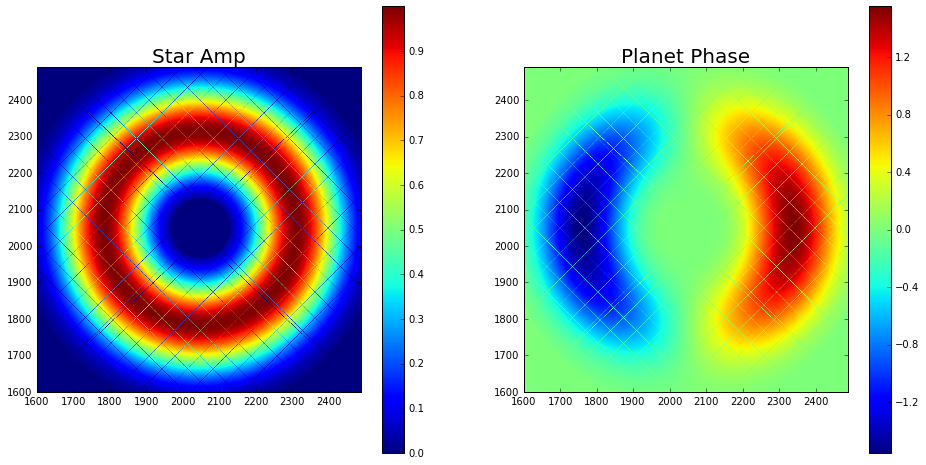

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(Str_amp_apo_h); plt.xlim(1600,2490); plt.ylim(1600,2490); plt.colorbar() 
plt.title('Star Amp', fontsize=20)

plt.subplot(122)
plt.imshow(Pnt_pha_apo_h.value); plt.xlim(1600,2490); plt.ylim(1600,2490); plt.colorbar() 
plt.title('Planet Phase', fontsize=20)

### First focal plane

In [18]:
Str_ffoc_ef = Ef_after(Str_amp_apo_h,Str_pha_apo_h)
Pnt_ffoc_ef = Ef_after(Pnt_amp_apo_h,Pnt_pha_apo_h)

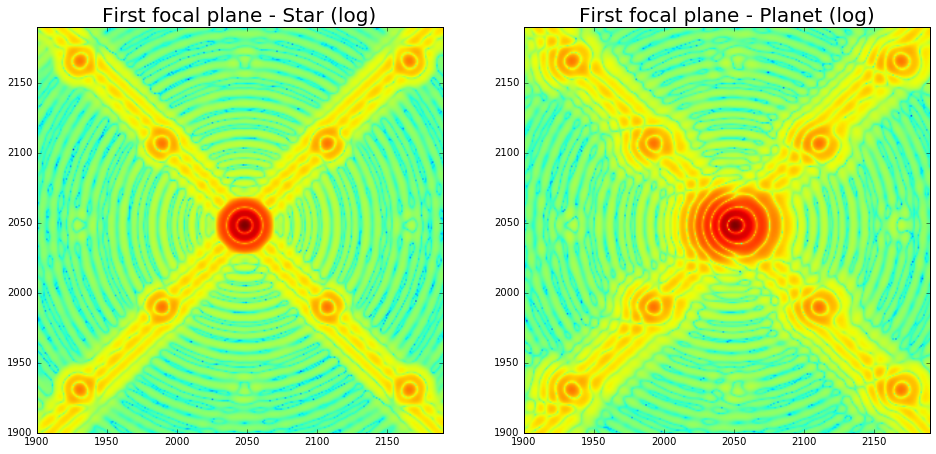

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_ffoc_ef)**2,origin='lower',norm=LogNorm())
plt.xlim(1900,2190); plt.ylim(1900,2190); plt.title('First focal plane - Star (log)',fontsize=20)

plt.subplot(122); plt.imshow(abs(Pnt_ffoc_ef)**2,origin='lower',norm=LogNorm())
plt.xlim(1900,2190); plt.ylim(1900,2190); plt.title('First focal plane - Planet (log)',fontsize=20)

Alright, the planet's phase shift causes the "smearing" of the image on the focal plane. Hence applying coronagraph below will remove the un-shifted star contribution:

### Coronagraph
#### Matching the grids
Now the pixel scale for the FTed image is

In [20]:
k_pix_arc

<Quantity 0.010492784591380375 arcsec>

whereas that of the FPM is

In [21]:
fpm_k_h['pixscale']

0.00263671875

the ratio (downsampling factor) is to reduce the FPM to a size of (round off to nearest even integer)

In [22]:
down_samp_f = k_pix_arc.value / fpm_k_h['pixscale']
N_pix_down  = int(fpm_k_h['NAXIS1'] / down_samp_f) + 1

In [23]:
%%capture 
#- ignoring the WARNINGs

##
fpm_h_down = zoomArray(fpm_h_d,(N_pix_down,N_pix_down))

## try to get rid of the artifacts
fpm_h_down[np.where(fpm_h_down<0.9)]=0

## padding to N_pix x N_pix
fpm_h_p = pad_array(fpm_h_down,N_pix,pad=1)

In [26]:
## centroid
ctx,cty = (N_pix-1)/2, (N_pix-1)/2

##
kx_min,kx_max = ((0-ctx)*k_pix_arc).value,((N_pix-ctx)*k_pix_arc).value
ky_min,ky_max = ((0-cty)*k_pix_arc).value,((N_pix-cty)*k_pix_arc).value

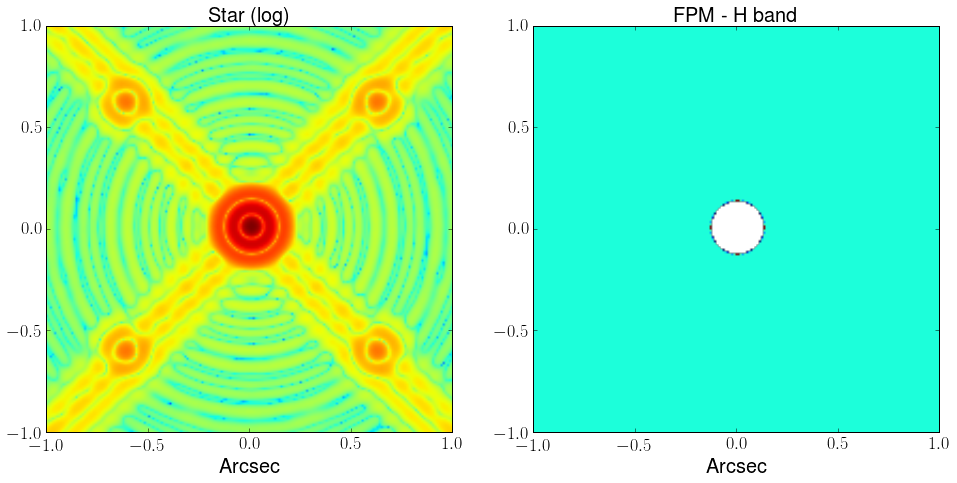

In [75]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_ffoc_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('Star (log)')
plt.xlabel('Arcsec')

plt.subplot(122); plt.imshow(fpm_h_p,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm())
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM - H band')
plt.xlabel('Arcsec')

Looks nice! The mask roughly matches the size of the first blob of the diffraction pattern and leaves the other features intact. (Indeed, the mask size in `arcsec` agrees with the documented specifications (e.g. [here](http://docs.planetimager.org/pipeline_dev/gpi_pipeline/documentation/gpireference/coronagraph.html#coronagraph-apodizer))

#### Masking

In [25]:
Str_coro_ef = Str_ffoc_ef * fpm_h_p
Pnt_coro_ef = Pnt_ffoc_ef * fpm_h_p

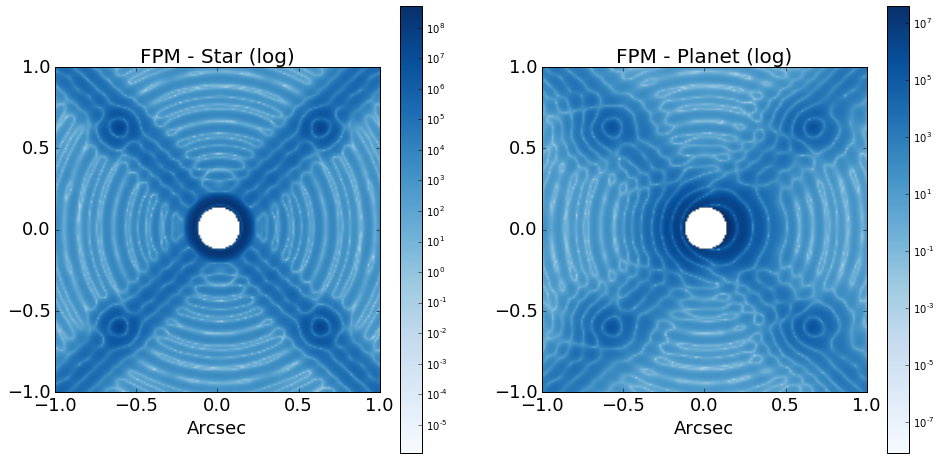

In [32]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_coro_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm(), \
                             cmap='Blues')
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM - Star (log)',fontsize=20)
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.xlabel('Arcsec', fontsize=18); plt.colorbar()

plt.subplot(122); plt.imshow(abs(Pnt_coro_ef)**2,origin='lower', \
                             extent=(kx_min,kx_max,ky_min,ky_max),norm=LogNorm(), \
                             cmap='Blues')
plt.xlim(-1,1); plt.ylim(-1,1); plt.title('FPM - Planet (log)',fontsize=20)
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.xlabel('Arcsec', fontsize=18); plt.colorbar()

OKay, the planet seems to remain "visible"

### Second pupil plane - Lyot
#### Transform back

In [78]:
Str_2pup_ef = Ef_ift_from_Ef(Str_coro_ef)
Pnt_2pup_ef = Ef_ift_from_Ef(Pnt_coro_ef)

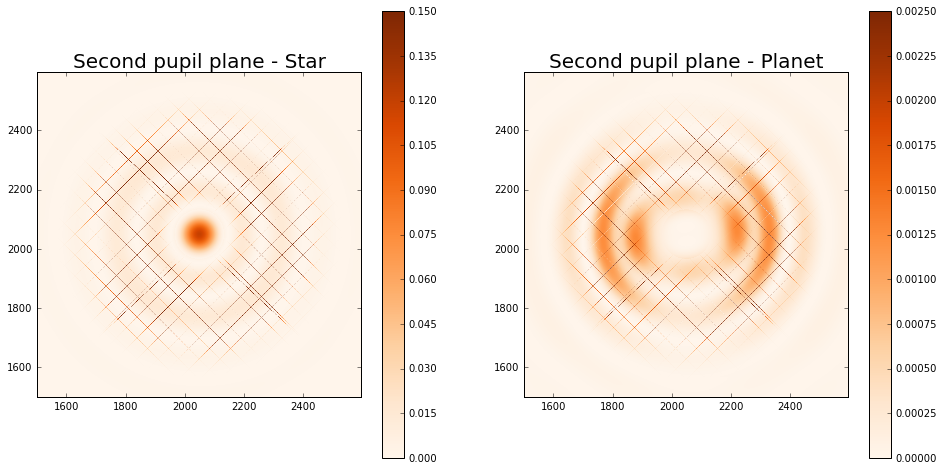

In [64]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_2pup_ef)**2,origin='lower',cmap='Oranges')#,norm=LogNorm())
plt.title('Second pupil plane - Star',fontsize=20); plt.clim(0,0.15)
plt.xlim(1500,2596); plt.ylim(1500,2596); plt.colorbar()

plt.subplot(122); plt.imshow(abs(Pnt_2pup_ef)**2,origin='lower',cmap='Oranges')#,norm=LogNorm())
plt.title('Second pupil plane - Planet',fontsize=20); plt.clim(0,0.0025)
plt.xlim(1500,2596); plt.ylim(1500,2596); plt.colorbar()

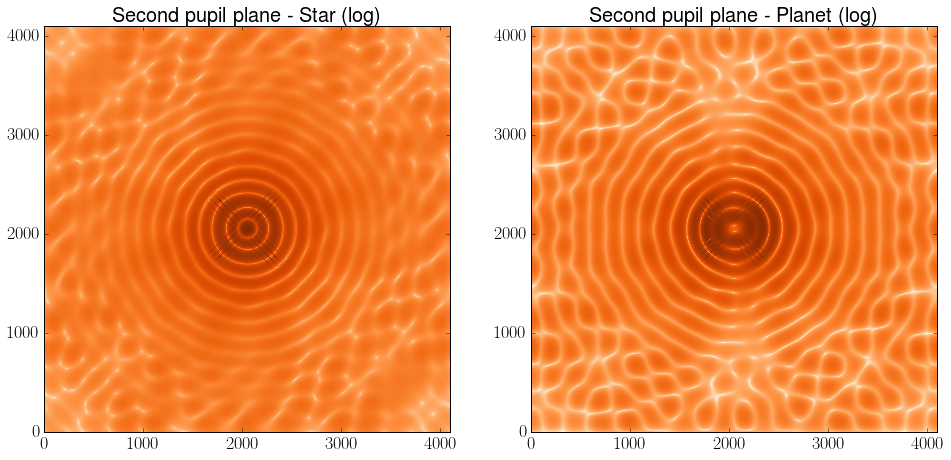

In [76]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_2pup_ef)**2,origin='lower',cmap='Oranges',norm=LogNorm())
plt.title('Second pupil plane - Star (log)',fontsize=20); plt.clim(1e-10,0.15)

plt.subplot(122); plt.imshow(abs(Pnt_2pup_ef)**2,origin='lower',cmap='Oranges',norm=LogNorm())
plt.title('Second pupil plane - Planet (log)',fontsize=20); plt.clim(1e-10,0.0025)

These are the full images, and we want to remove the (imperfect) ripples

#### Lyot

In [54]:
Str_lyo_ef = Str_2pup_ef * lyo_h_p
Pnt_lyo_ef = Pnt_2pup_ef * lyo_h_p

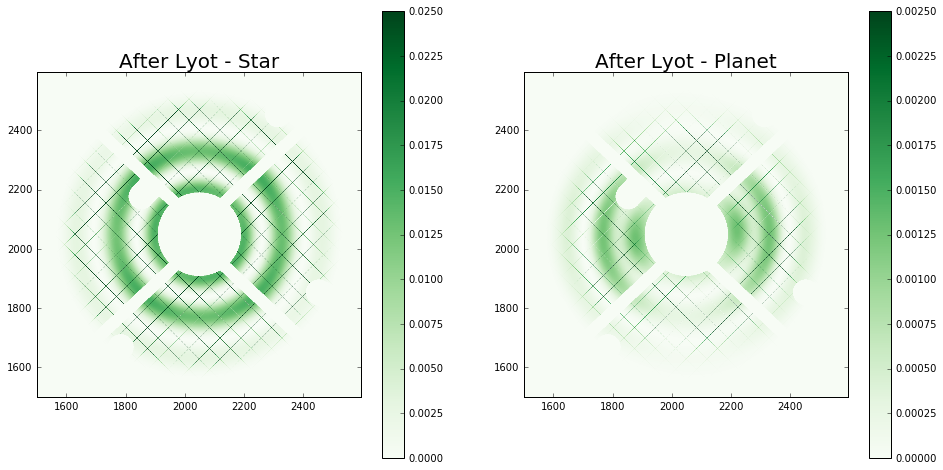

In [66]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(abs(Str_lyo_ef)**2,origin='lower',cmap='Greens')
plt.xlim(1500,2596); plt.ylim(1500,2596); plt.title('After Lyot - Star',fontsize=20)
plt.clim(0,0.025); plt.colorbar()

plt.subplot(122); plt.imshow(abs(Pnt_lyo_ef)**2,origin='lower',cmap='Greens')
plt.xlim(1500,2596); plt.ylim(1500,2596); plt.title('After Lyot - Planet',fontsize=20)
plt.clim(0,0.0025); plt.colorbar()

Not sure if this is right

### Final image

In [ ]:
Str_lyo_ef
Pnt_lyo_ef

Str_final_ef = Ef_after(Str_amp_apo_h,Str_pha_apo_h)
Pnt_final_ef = Ef_after(Pnt_amp_apo_h,Pnt_pha_apo_h)

In the logarithmic scale (they are rather dim...), the "satellites" are conspicuous.

---
## Some testing images for reference...

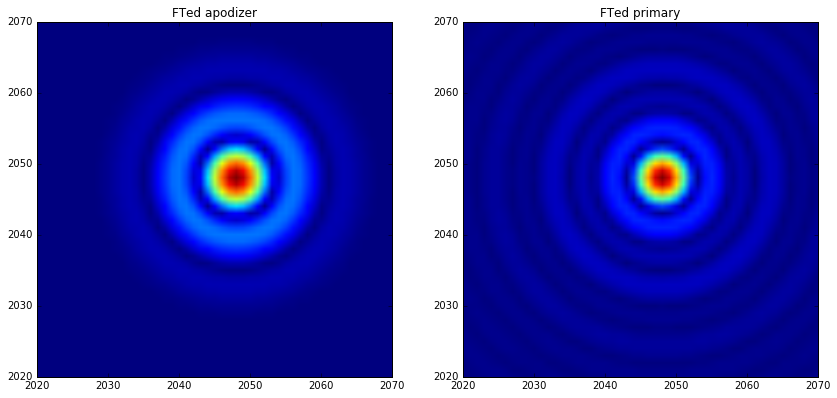

In [265]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(abs(np.fft.fftshift(np.fft.fft2(apo_h_p))),origin='lower')
plt.xlim(2020,2070); plt.ylim(2020,2070); plt.title('FTed apodizer')
plt.subplot(122)
plt.imshow(abs(np.fft.fftshift(np.fft.fft2(pri_p))),origin='lower')
plt.xlim(2020,2070); plt.ylim(2020,2070); plt.title('FTed primary')

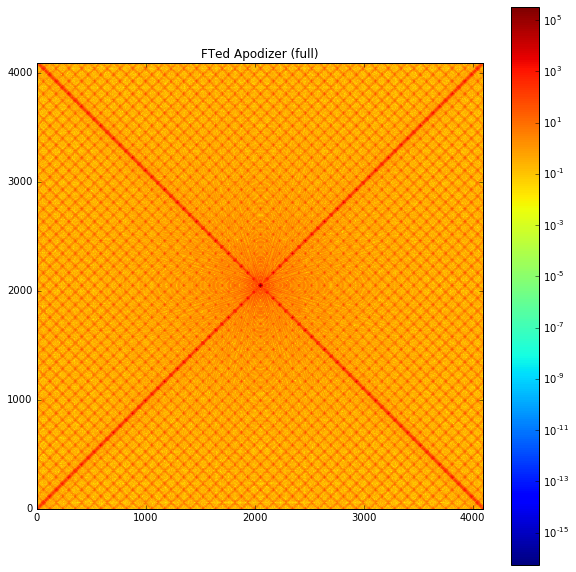

In [282]:
plt.figure(figsize=(10,10))
dtest = abs(np.fft.fftshift(np.fft.fft2(apo_h_p)))
plt.imshow(dtest,origin='lower', norm=LogNorm()); plt.colorbar()
plt.title('FTed Apodizer (full)')